# calculate and plot areas of all clusters and visualize in bar chart

#### imports

In [316]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial
import pyproj
from scipy.ndimage import gaussian_filter

In [25]:
SE_Pacific = pd.read_csv('cluster_0_data.csv')
Europe = pd.read_csv('cluster_3_data.csv')
SW_SA = pd.read_csv('cluster_5_data.csv')
S_Pacific_Islands = pd.read_csv('cluster_6_data.csv')
Alaska_Canada = pd.read_csv('cluster_7_data.csv')
Brazil = pd.read_csv('cluster_10_data.csv')
Caribbean_Florida = pd.read_csv('cluster_12_data.csv')
Indian_Ocean = pd.read_csv('cluster_14_data.csv')
Asia = pd.read_csv('cluster_16_data.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### beach times

In [310]:
# find the last time to beach so we can determine a year trajectory
# (by subtracting 1 year in seconds)

# this method is not used due to time_to_beach being more convenient!

def last_beach_time(beach):
    
    beach_reverse = beach.sort_values(by=['id', 'time'], ascending=[True, False])
    beach_end = beach_reverse.drop_duplicates(subset='id', keep='first')
    beach_end.reset_index(drop=True, inplace=True)
    
   
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    ids = beach_undrogued_end['id'].values
    lats = beach_undrogued_end['lat'].values
    lons = beach_undrogued_end['lon'].values
    ves = beach_undrogued_end['ve'].values
    vns = beach_undrogued_end['vn'].values
    times = beach_undrogued_end['time_to_beach'].values

    print("ended")

    return ids, lats, lons, ves, vns, times


In [311]:
# as long as the trajectory is longer than a year (i.e. has 1 year in time_to_beach)
# append all values less than 1 year to beaching

def year_to_beach(cluster):

    year = 31536000
    
    if (cluster['time_to_beach'] == year).any():
        filtered_cluster = cluster[cluster['time_to_beach'] <= year]
    return filtered_cluster

In [278]:
def six_to_beach(cluster):

    six = 15638400
    
    if (cluster['time_to_beach'] == six).any():
        filtered_cluster = cluster[cluster['time_to_beach'] <= six]
    return filtered_cluster

In [279]:
def three_to_beach(cluster):

    three = 7776000
    
    if (cluster['time_to_beach'] == three).any():
        filtered_cluster = cluster[cluster['time_to_beach'] <= three]
    return filtered_cluster

In [298]:
def one_to_beach(cluster):

    one = 2629800
    
    if (cluster['time_to_beach'] <= one).any():
        filtered_cluster = cluster[cluster['time_to_beach'] <= one]
    return filtered_cluster

#### heatmaps, etc functions

In [312]:
def plot_density_heatmap(latitudes, longitudes, lat_bins, lon_bins, ax, cmap='viridis'):

    heatmap_data, lat_edges, lon_edges = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)
    
    # normalize data
    heatmap_data_normalized = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    # bin ceenters
    lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
    lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2

    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data_normalized, cmap=cmap, transform=ccrs.PlateCarree())

    # change "levels" to modify contours
    contour = plt.contour(lon_centers, lat_centers, heatmap_data_normalized, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    return mesh, contour

In [313]:
# processing
def convert_to_numeric(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

In [314]:
# grid cells, bins, QOL
n_lons, n_lats = 135, 85
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

dataframes = {
    'SE_Pacific': 'cluster_0_data.csv',
    'Europe': 'cluster_3_data.csv',
    'SW_SA': 'cluster_5_data.csv',
    'S_Pacific_Islands': 'cluster_6_data.csv',
    'Alaska_Canada': 'cluster_7_data.csv',
    'Brazil': 'cluster_10_data.csv',
    'Caribbean_Florida': 'cluster_12_data.csv',
    'Indian_Ocean': 'cluster_14_data.csv',
    'Asia': 'cluster_16_data.csv'
}

#### all clusters 1 year contour map

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


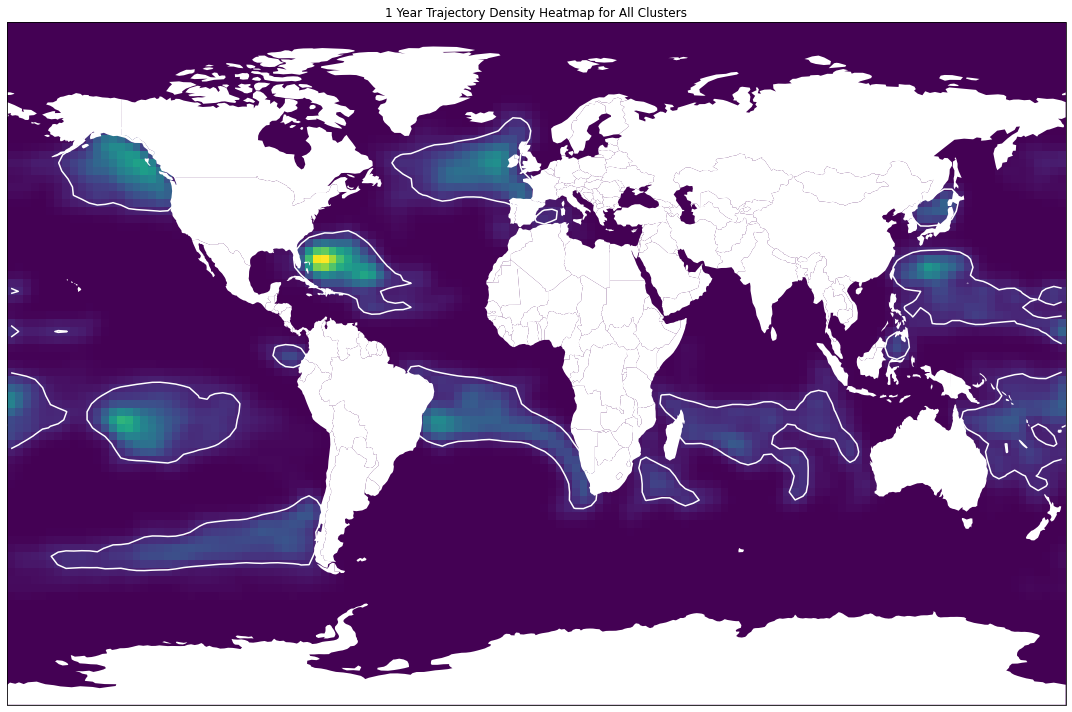

In [324]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 10))
aggregated_heatmap_data = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

for region, filepath in dataframes.items():
    data = pd.read_csv(filepath)
    data = convert_to_numeric(data, ['lat', 'lon'])
    filtered_data = year_to_beach(data)

    latitudes = filtered_data['lat'].values
    longitudes = filtered_data['lon'].values

    heatmap_data, lat_edges, lon_edges = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)
    resized_heatmap_data = np.resize(heatmap_data, (aggregated_heatmap_data.shape[0], aggregated_heatmap_data.shape[1]))
    aggregated_heatmap_data += resized_heatmap_data

# gaussian blur
aggregated_heatmap_data_blurred = gaussian_filter(aggregated_heatmap_data, sigma=1)

# normalize
aggregated_heatmap_data_normalized = (aggregated_heatmap_data_blurred - np.min(aggregated_heatmap_data_blurred)) / (np.max(aggregated_heatmap_data_blurred) - np.min(aggregated_heatmap_data_blurred))

lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2

mesh = ax.pcolormesh(lon_centers, lat_centers, aggregated_heatmap_data_normalized, cmap='viridis', transform=ccrs.PlateCarree())
contour = ax.contour(lon_centers, lat_centers, aggregated_heatmap_data_normalized, levels=[0.1], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

ax.set_aspect('auto')
ax.set_title('1 Year Trajectory Density Heatmap for All Clusters')
plt.tight_layout()
plt.show()

#### data functions, generate heatmaps and contours

In [325]:
def preprocess_data(df):
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df.dropna(subset=['lat', 'lon'], inplace=True)

    return df

In [326]:
def generate_heatmap_and_contour_yr(cluster_file):
    data = pd.read_csv(cluster_file)
    data = year_to_beach(data)
    data = preprocess_data(data)

    latitudes = data['lat'].values
    longitudes = data['lon'].values
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap='viridis', transform=ccrs.PlateCarree())

    contour = ax.contour(lon_centers, lat_centers, heatmap_data, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    # extract contours
    contour_lats = []
    contour_lons = []
    for collection in contour.collections:
        paths = collection.get_paths()
        for path in paths:
            vertices = path.vertices
            contour_lats.extend(vertices[:, 1])
            contour_lons.extend(vertices[:, 0])

    return contour_lats, contour_lons

In [327]:
def generate_heatmap_and_contour_six(cluster_file):
    data = pd.read_csv(cluster_file)
    data = six_to_beach(data)
    data = preprocess_data(data)

    latitudes = data['lat'].values
    longitudes = data['lon'].values
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap='viridis', transform=ccrs.PlateCarree())

    contour = ax.contour(lon_centers, lat_centers, heatmap_data, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    # extract contours
    contour_lats = []
    contour_lons = []
    for collection in contour.collections:
        paths = collection.get_paths()
        for path in paths:
            vertices = path.vertices
            contour_lats.extend(vertices[:, 1])
            contour_lons.extend(vertices[:, 0])

    return contour_lats, contour_lons

In [328]:
def generate_heatmap_and_contour_three(cluster_file):
    data = pd.read_csv(cluster_file)
    data = three_to_beach(data)
    data = preprocess_data(data)

    latitudes = data['lat'].values
    longitudes = data['lon'].values
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap='viridis', transform=ccrs.PlateCarree())

    contour = ax.contour(lon_centers, lat_centers, heatmap_data, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    # extract contours
    contour_lats = []
    contour_lons = []
    for collection in contour.collections:
        paths = collection.get_paths()
        for path in paths:
            vertices = path.vertices
            contour_lats.extend(vertices[:, 1])
            contour_lons.extend(vertices[:, 0])

    return contour_lats, contour_lons

In [284]:
def generate_heatmap_and_contour_one(cluster_file):
    data = pd.read_csv(cluster_file)
    data = one_to_beach(data)
    data = preprocess_data(data)

    latitudes = data['lat'].values
    longitudes = data['lon'].values
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap='viridis', transform=ccrs.PlateCarree())

    contour = ax.contour(lon_centers, lat_centers, heatmap_data, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    # extract contours
    contour_lats = []
    contour_lons = []
    for collection in contour.collections:
        paths = collection.get_paths()
        for path in paths:
            vertices = path.vertices
            contour_lats.extend(vertices[:, 1])
            contour_lons.extend(vertices[:, 0])

    return contour_lats, contour_lons

In [329]:
def calculate_projected_area(latitudes, longitudes):
    # define maximum and minimum lats and lons
    lat_1 = np.min(latitudes)
    lat_2 = np.max(latitudes)
    lat_0 = np.mean(latitudes)
    lon_0 = np.mean(longitudes)
    
    # define equal area projection
    pa = Proj(f"+proj=aea +lat_1={lat_1} +lat_2={lat_2} +lat_0={lat_0} +lon_0={lon_0}")
    
    # project
    x, y = pa(longitudes, latitudes)
    
    # projected GeoJSON
    projected_geojson = {"type": "Polygon", "coordinates": [list(zip(x, y))]}
    projected_shape = shape(projected_geojson)
    
    area = projected_shape.area
    
    return area

#### calculate areas

/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within 

One year area of SE_Pacific: 20537172.331707805 square kilometers
One year area of Europe: 14299992.731799116 square kilometers
One year area of SW_SA: 17665299.076182596 square kilometers
One year area of S_Pacific_Islands: 81282789.46859996 square kilometers
One year area of Alaska_Canada: 10530125.996650536 square kilometers
One year area of Brazil: 14696715.65380945 square kilometers
One year area of Caribbean_Florida: 13373524.615391178 square kilometers
One year area of Indian_Ocean: 29290293.472075175 square kilometers
One year area of Asia: 12287328.845717644 square kilometers


/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


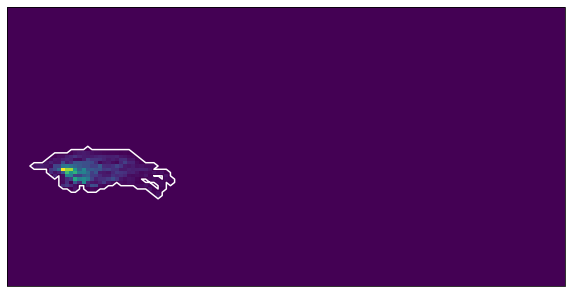

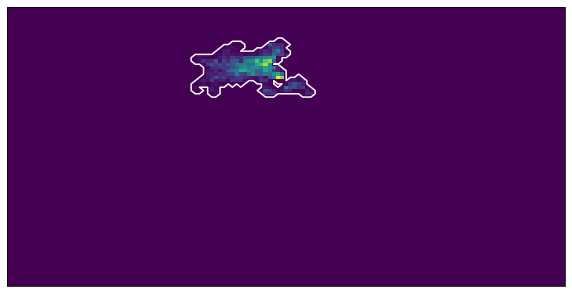

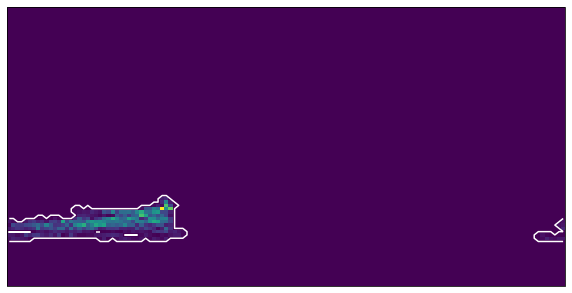

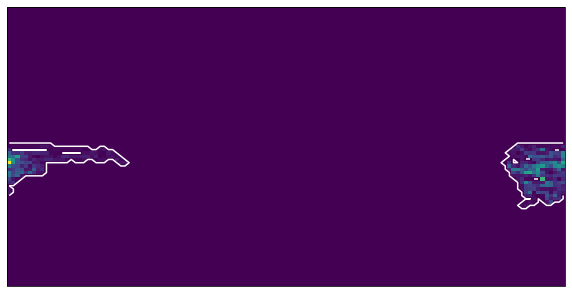

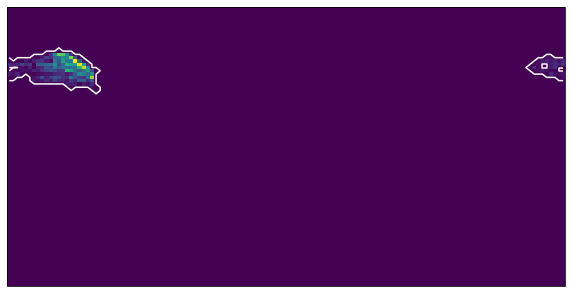

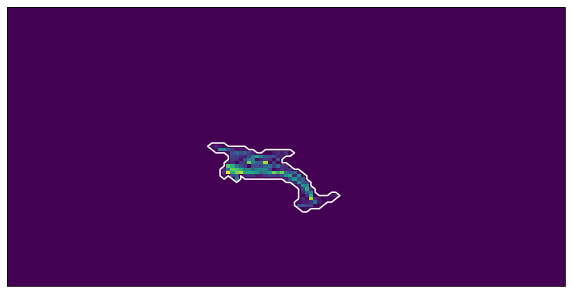

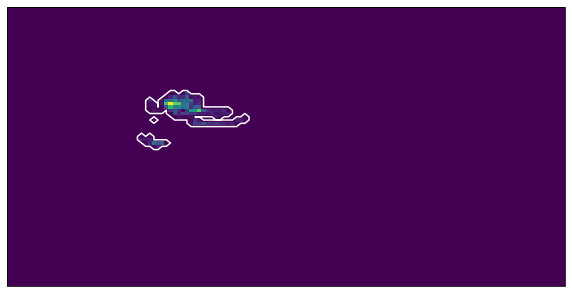

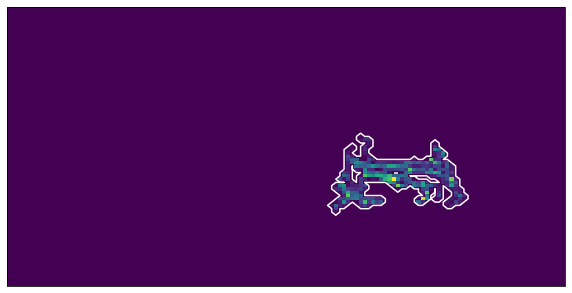

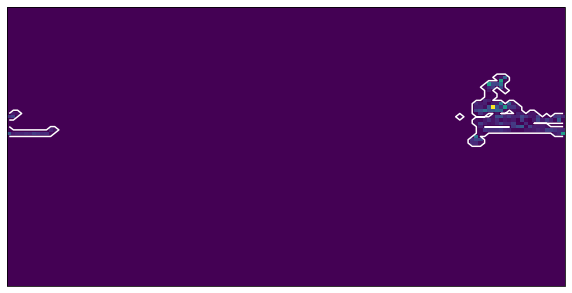

In [330]:
yr_areas = {}
for cluster_name, file_path in dataframes.items():
    latitudes, longitudes = generate_heatmap_and_contour_yr(file_path)

    area = calculate_projected_area(latitudes, longitudes)
    yr_areas[cluster_name] = area

# print
for cluster_name, area in yr_areas.items():
    area_km2 = area / 10**6
    print(f"One year area of {cluster_name}: {area_km2} square kilometers")

/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within 

6 month area of SE_Pacific: 13369780.457539499 square kilometers
6 month area of Europe: 10229711.467828833 square kilometers
6 month area of SW_SA: 10284228.26290046 square kilometers
6 month area of S_Pacific_Islands: 73120895.64897388 square kilometers
6 month area of Alaska_Canada: 8293823.758153586 square kilometers
6 month area of Brazil: 10527089.534324383 square kilometers
6 month area of Caribbean_Florida: 7860147.112916066 square kilometers
6 month area of Indian_Ocean: 16427554.555064013 square kilometers
6 month area of Asia: 3639560.88167521 square kilometers


/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


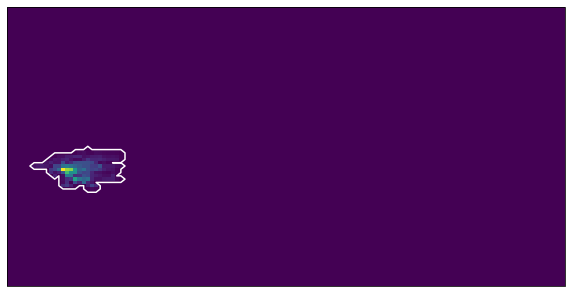

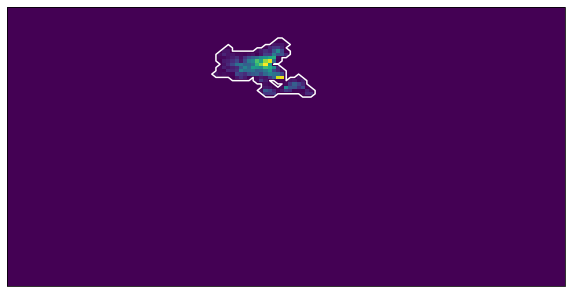

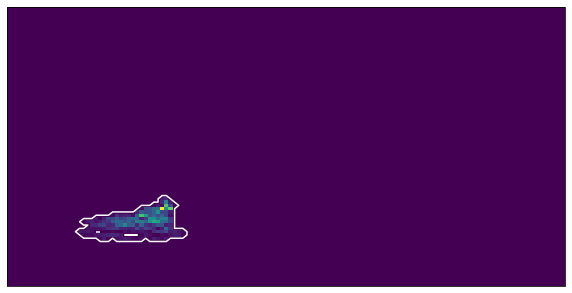

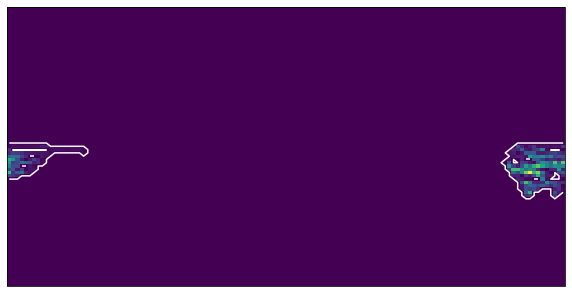

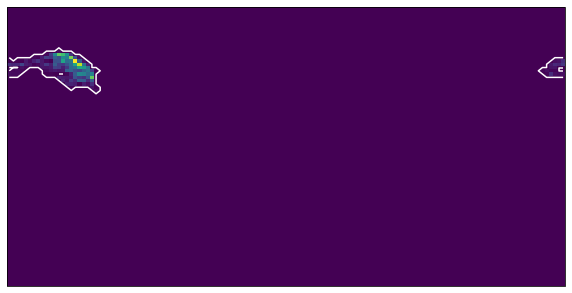

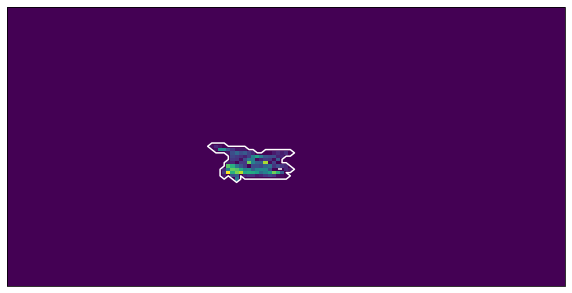

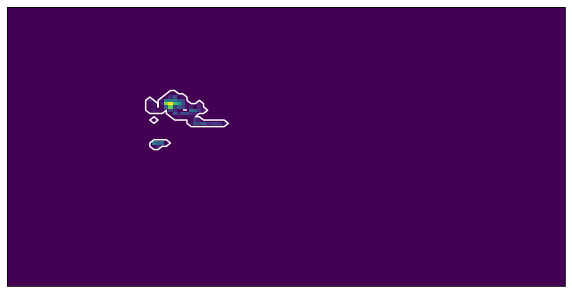

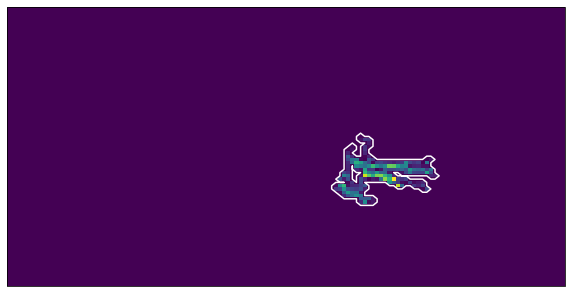

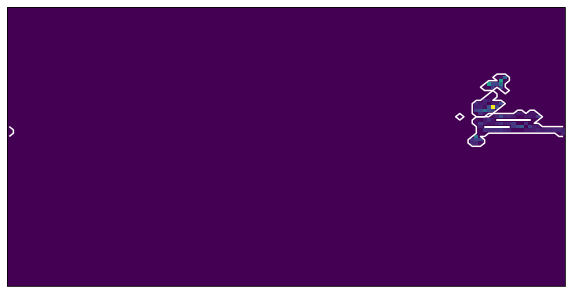

In [331]:
six_areas = {}
for cluster_name, file_path in dataframes.items():
    latitudes, longitudes = generate_heatmap_and_contour_six(file_path)

    area = calculate_projected_area(latitudes, longitudes)
    six_areas[cluster_name] = area

# print
for cluster_name, area in six_areas.items():
    area_km2 = area / 10**6
    print(f"6 month area of {cluster_name}: {area_km2} square kilometers")

/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within 

3 month area of SE_Pacific: 9875042.088770458 square kilometers
3 month area of Europe: 8272569.527729879 square kilometers
3 month area of SW_SA: 6106283.991315315 square kilometers
3 month area of S_Pacific_Islands: 14590161.486216504 square kilometers
3 month area of Alaska_Canada: 6081165.916405443 square kilometers
3 month area of Brazil: 6538562.295542303 square kilometers
3 month area of Caribbean_Florida: 7957442.388078611 square kilometers
3 month area of Indian_Ocean: 12021295.212898958 square kilometers
3 month area of Asia: 9155683.668068126 square kilometers


/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


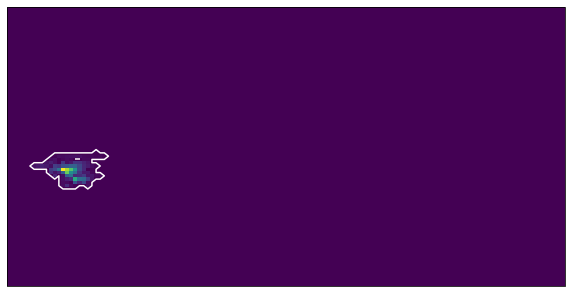

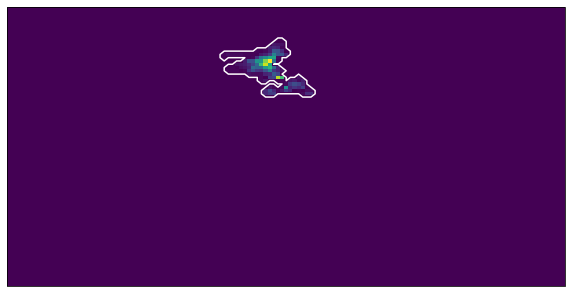

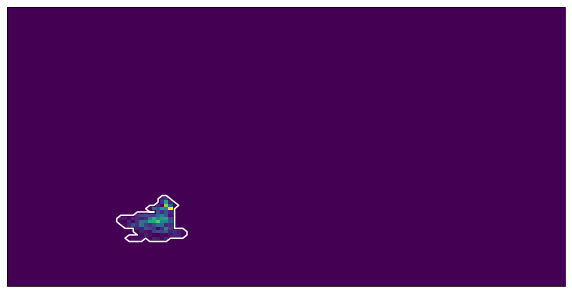

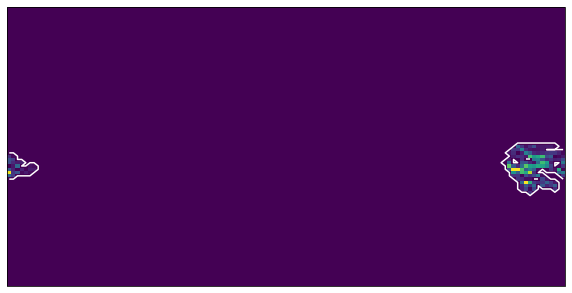

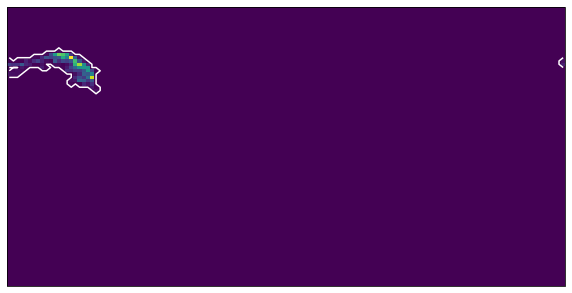

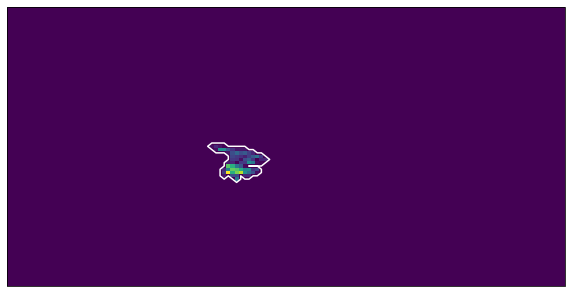

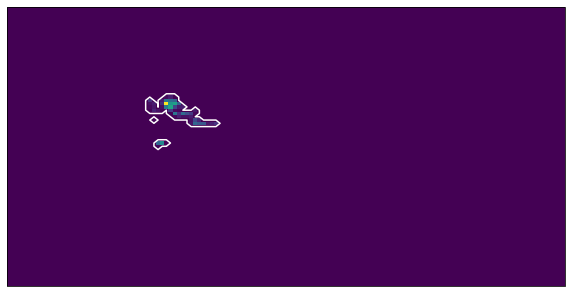

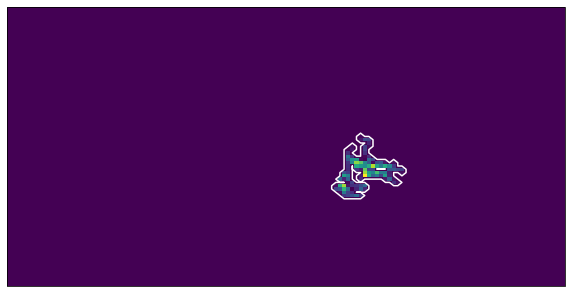

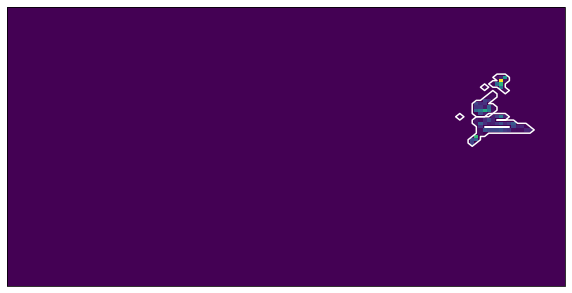

In [332]:
three_areas = {}
for cluster_name, file_path in dataframes.items():
    latitudes, longitudes = generate_heatmap_and_contour_three(file_path)
    
    area = calculate_projected_area(latitudes, longitudes)
    three_areas[cluster_name] = area

# print
for cluster_name, area in three_areas.items():
    area_km2 = area / 10**6
    print(f"3 month area of {cluster_name}: {area_km2} square kilometers")

In [ ]:
one_areas = {}
for cluster_name, file_path in dataframes.items():
    latitudes, longitudes = generate_heatmap_and_contour_one(file_path)

    area = calculate_projected_area(latitudes, longitudes)
    one_areas[cluster_name] = area

# print
for cluster_name, area in one_areas.items():
    area_km2 = area / 10**6
    print(f"3 month area of {cluster_name}: {area_km2} square kilometers")

/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within 

#### individual bar charts

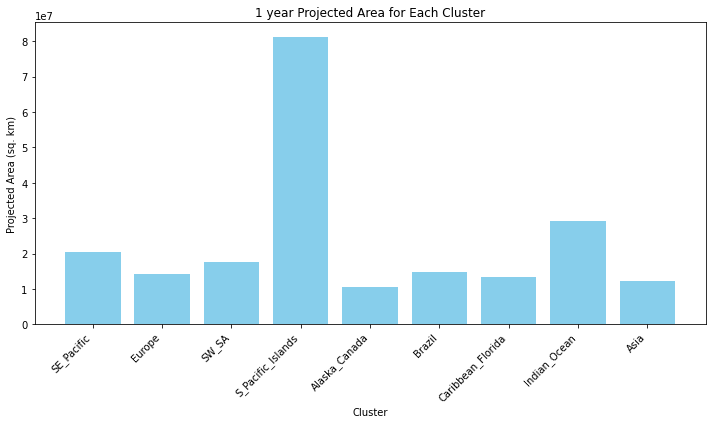

In [297]:
projected_areas_km2 = {cluster_name: area / 10**6 for cluster_name, area in yr_areas.items()}

plt.figure(figsize=(10, 6))
plt.bar(projected_areas_km2.keys(), projected_areas_km2.values(), color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Projected Area (sq. km)')
plt.title('1 year Projected Area for Each Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


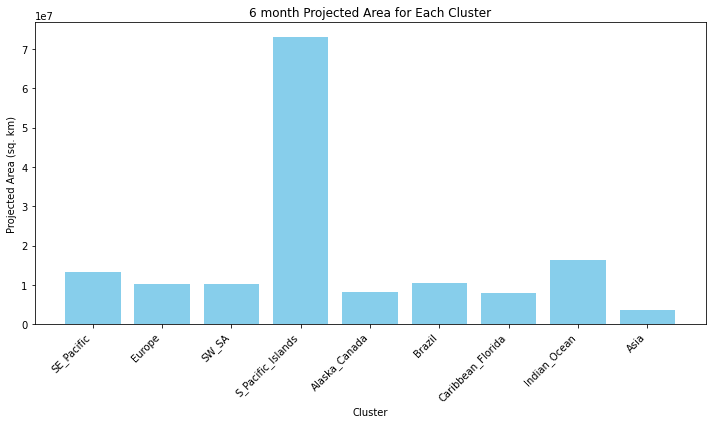

In [301]:
projected_areas_km2 = {cluster_name: area / 10**6 for cluster_name, area in six_areas.items()}

plt.figure(figsize=(10, 6))
plt.bar(projected_areas_km2.keys(), projected_areas_km2.values(), color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Projected Area (sq. km)')
plt.title('6 month Projected Area for Each Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


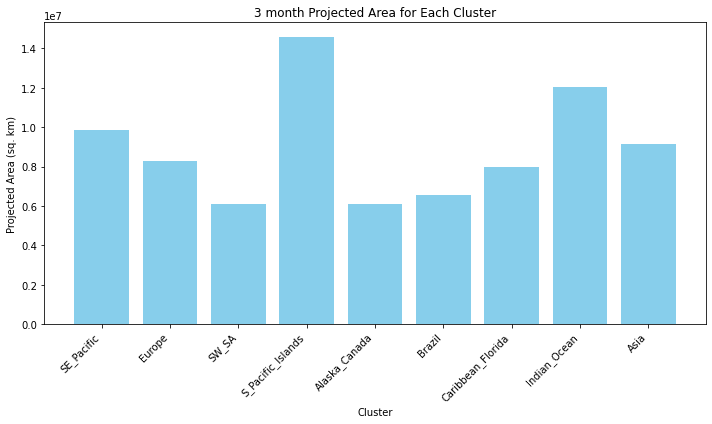

In [302]:
projected_areas_km2 = {cluster_name: area / 10**6 for cluster_name, area in three_areas.items()}

plt.figure(figsize=(10, 6))
plt.bar(projected_areas_km2.keys(), projected_areas_km2.values(), color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Projected Area (sq. km)')
plt.title('3 month Projected Area for Each Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


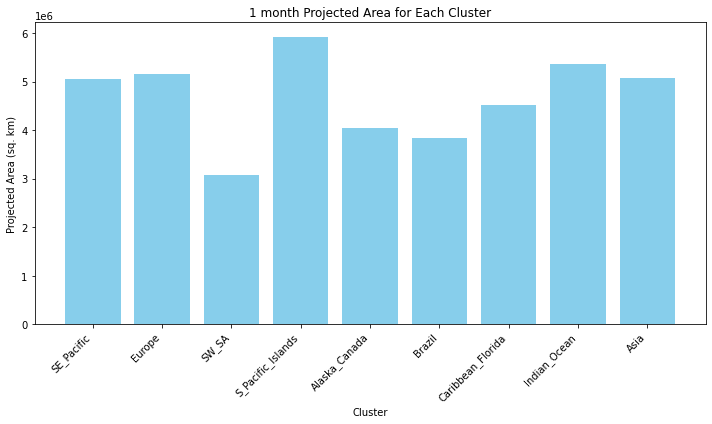

In [303]:
projected_areas_km2 = {cluster_name: area / 10**6 for cluster_name, area in one_areas.items()}

plt.figure(figsize=(10, 6))
plt.bar(projected_areas_km2.keys(), projected_areas_km2.values(), color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Projected Area (sq. km)')
plt.title('1 month Projected Area for Each Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### all clusters bar chart

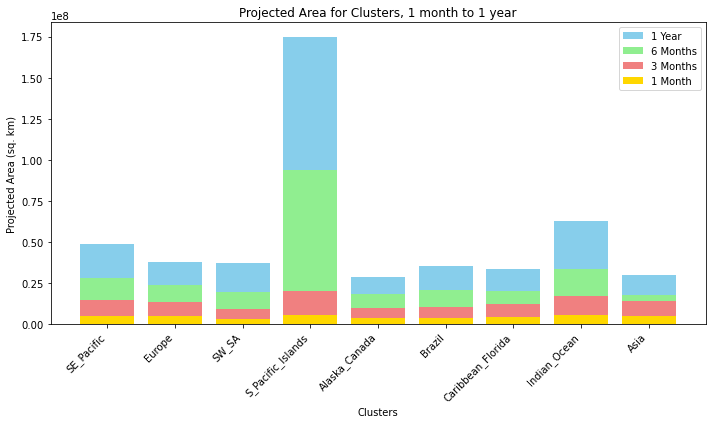

In [309]:
# Convert areas to square kilometers
yr_areas_km2 = {cluster: area / 10**6 for cluster, area in yr_areas.items()}
six_areas_km2 = {cluster: area / 10**6 for cluster, area in six_areas.items()}
three_areas_km2 = {cluster: area / 10**6 for cluster, area in three_areas.items()}
one_areas_km2 = {cluster: area / 10**6 for cluster, area in one_areas.items()}

# Cluster names
clusters = list(yr_areas_km2.keys())

# Heights for each stacked bar
yr_heights = np.array([yr_areas_km2[cluster] for cluster in clusters])
six_heights = np.array([six_areas_km2[cluster] for cluster in clusters])
three_heights = np.array([three_areas_km2[cluster] for cluster in clusters])
one_heights = np.array([one_areas_km2[cluster] for cluster in clusters])

# Plotting
plt.figure(figsize=(10, 6))

# Bottom positions for each group of bars
bottom_three = one_heights
bottom_six = bottom_three + three_heights
bottom_yr = bottom_six + six_heights

# Stacked bar chart
plt.bar(clusters, one_heights, color='gold', label='1 Month')
plt.bar(clusters, three_heights, bottom=bottom_three, color='lightcoral', label='3 Months')
plt.bar(clusters, six_heights, bottom=bottom_six, color='lightgreen', label='6 Months')
plt.bar(clusters, yr_heights, bottom=bottom_yr, color='skyblue', label='1 Year')

plt.xlabel('Clusters')
plt.ylabel('Projected Area (sq. km)')
plt.title('Projected Area for Clusters, 1 month to 1 year')
plt.xticks(rotation=45, ha='right')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

plt.tight_layout()
plt.show()
